<a href="https://colab.research.google.com/github/Aloxxa/Credit.../blob/main/PyCaret_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1YCu8yeQa1vS8SYu-NpHnO57NvL2gQwyo

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YCu8yeQa1vS8SYu-NpHnO57NvL2gQwyo
To: /content/credit_data.csv
100% 86.2k/86.2k [00:00<00:00, 66.7MB/s]


# Libraries

In [ ]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 52.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of selenium to determine which version is compatible with other requirements. This c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#####
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score,recall_score, fbeta_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix, make_scorer
#####
from pycaret.classification import *
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
#####
import joblib
#####
plt.style.use('dark_background')

# Class

In [ ]:
class Helper:

    @staticmethod
    def load(read, info = True):
        import io
        if info:
            if len(read) > 0:
                print("# Data imported!")
                print("# ------------------------------------", "\n")
                print("# DIMENSIONS -------------------------")
                print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
                print("# DTYPES -----------------------------")
                if len(read.select_dtypes("object").columns) > 0:
                    print("Object Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("object").columns), "\n",
                          read.select_dtypes("object").columns.tolist(), "\n")
                if len(read.select_dtypes("integer").columns) > 0:
                    print("Integer Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("integer").columns), "\n",
                          read.select_dtypes("integer").columns.tolist(), "\n")
                if len(read.select_dtypes("float").columns) > 0:
                    print("Float Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("float").columns), "\n",
                          read.select_dtypes("float").columns.tolist(), "\n")
                if len(read.select_dtypes("bool").columns) > 0:
                    print("Bool Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("bool").columns), "\n",
                          read.select_dtypes("bool").columns.tolist(), "\n")
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
            print("# DESCRIBE ---------------------")
            numerical_columns = read.select_dtypes(include=[np.number])
            print(pd.concat([numerical_columns.describe().T,
                        numerical_columns.skew().rename('skew'),
                        numerical_columns.kurt().rename('kurt'),
                        ], axis=1).T)
            print()
            print("# DUPLICATES  ---------------------")
            data_duplicates = read[read.duplicated()]
            if len(data_duplicates) == 0:
              print("There are no duplicates here")
            else:
              print("Here", len(data_duplicates), "duplicates")
              print(data_duplicates)
            print()
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False,
                                                                "No missing value!", "Data includes missing value!"), "\n")
        return None

    @staticmethod
    def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

    @staticmethod
    def fill_missing_values(df):
        imputer = KNNImputer()
        df_filled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
        return df_filled

    @staticmethod
    def feature_distribution_all(df):
        numeric_columns = df.select_dtypes(["integer", "float"]).columns.tolist()
        fig = plt.figure(figsize=(17, 40))
        rows, cols = 10, 3
        for idx, num in enumerate(numeric_columns[:30]):
            ax = fig.add_subplot(rows, cols, idx+1)
            ax.grid(alpha=0.7, axis="both")
            sns.kdeplot(x=num, fill=True, color="#3386FF", linewidth=0.6, hue=df.columns[-1], data=df)
        fig.tight_layout()
        plt.show()

    @staticmethod
    def pairplot_with_hue(df):
        numeric_columns = df.select_dtypes(include=['int', 'float']).columns
        sns.pairplot(df, hue=df.columns[-1], vars=numeric_columns)
        plt.show()

    @staticmethod
    def plot_numeric_correlation_heatmap(df_num, figsize):
        plt.figure(figsize=figsize)
        sns.heatmap(df_num.corr(), annot=True)
        plt.title('Correlation Heatmap')

    @staticmethod
    def y_propotion(df):
        colors = sns.color_palette('dark')[0:5]
        df.iloc[:,-1].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%.0f%%')
        plt.show()

    @staticmethod
    def split_data(df, test_size=0.30, validation_size=0.50, random_state=42):
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=random_state)
        df_train = pd.concat([X_train, y_train], axis=1)
        df_val = pd.concat([X_val, y_val], axis=1)
        df_test = pd.concat([X_test, y_test], axis=1)
        return df_train, df_val, df_test, X_train, y_train, X_val, y_val, X_test, y_test

    @staticmethod
    def stand_scale_columns(df):
        scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[df.columns] = scaler.fit_transform(df[df.columns])
        df_scaled = df_scaled.round(5)
        return df_scaled

helper = Helper()

# Import

In [ ]:
data = pd.read_csv('/content/credit_data.csv')
df = data.copy()

In [ ]:
df.sample(1)

,clientid,income,age,loan,default
683,684,57746.58159,63.625305,727.194665,0


# First view

In [ ]:
df

,clientid,income,age,loan,default
0,1,66155.92510,59.017015,8106.532131,0
1,2,34415.15397,48.117153,6564.745018,0
2,3,57317.17006,63.108049,8020.953296,0
3,4,42709.53420,45.751972,6103.642260,0
4,5,66952.68885,18.584336,8770.099235,1
...,...,...,...,...,...
1995,1996,59221.04487,48.518179,1926.729397,0
1996,1997,69516.12757,23.162104,3503.176156,0
1997,1998,44311.44926,28.017167,5522.786693,1
1998,1999,43756.05660,63.971796,1622.722598,0


In [ ]:
df.drop(['clientid'], axis=1, inplace=True)

In [ ]:
helper.load(df)

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 2000 Column: 4 

# DTYPES -----------------------------
Integer Variables: 
 # of Variables: 1 
 ['default'] 

Float Variables: 
 # of Variables: 3 
 ['income', 'age', 'loan'] 

# MEMORY USAGE ---------------------- 
 62.6 KB
# DESCRIBE ---------------------
             income          age          loan      default
count   2000.000000  1997.000000   2000.000000  2000.000000
mean   45331.600018    40.807559   4444.369695     0.141500
std    14326.327119    13.624469   3045.410024     0.348624
min    20014.489470   -52.423280      1.377630     0.000000
25%    32796.459720    28.990415   1939.708847     0.000000
50%    45789.117310    41.317159   3974.719418     0.000000
75%    57791.281670    52.587040   6432.410625     0.000000
max    69995.685580    63.971796  13766.051240     1.000000
skew      -0.042621    -0.307964      0.624284     2.058717
kurt      -1.201708     0.54944

In [ ]:
df = df[df['age']> 0]

In [ ]:
helper.missing_values_table(df)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# EDA

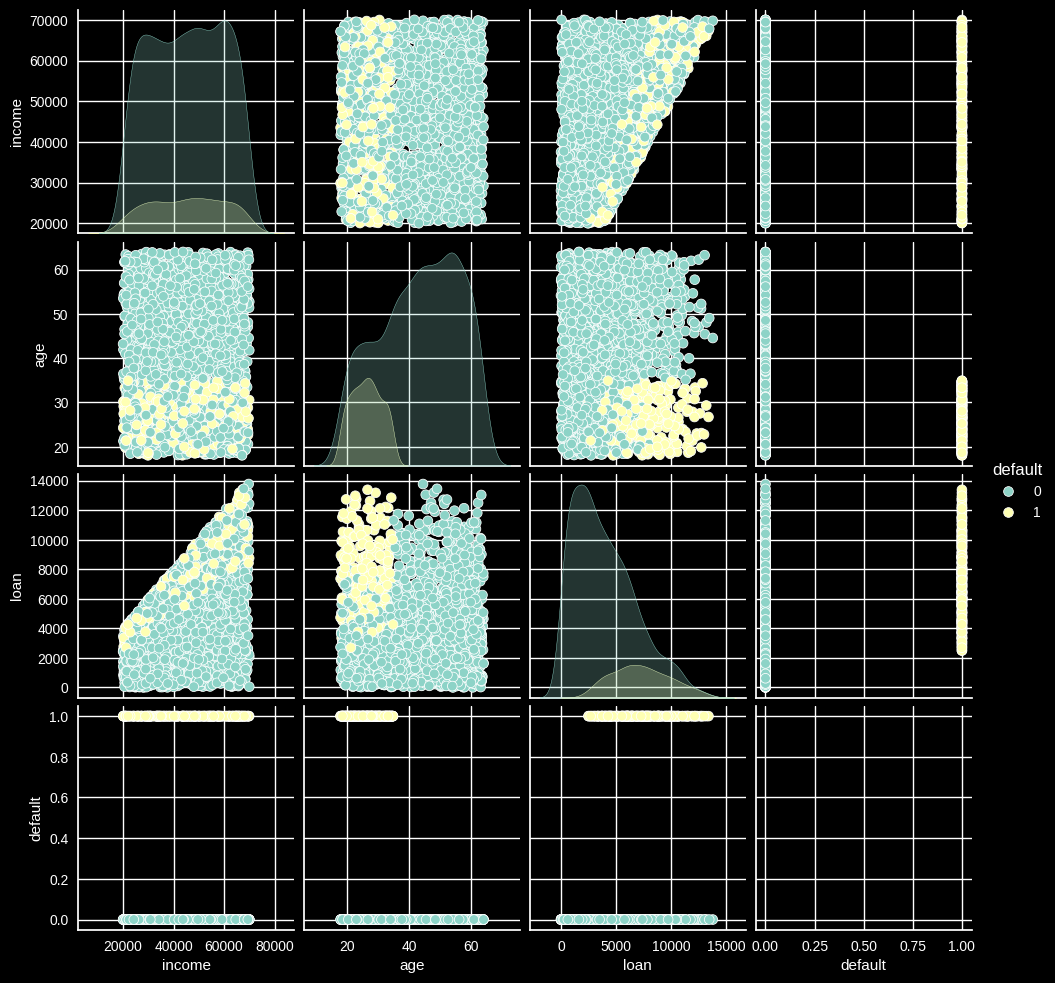

In [ ]:
helper.pairplot_with_hue(df)

In [ ]:
df.groupby('default').mean().T

default,0,1
income,45315.073824,45412.188607
age,43.330354,26.401412
loan,3975.221437,7272.856747


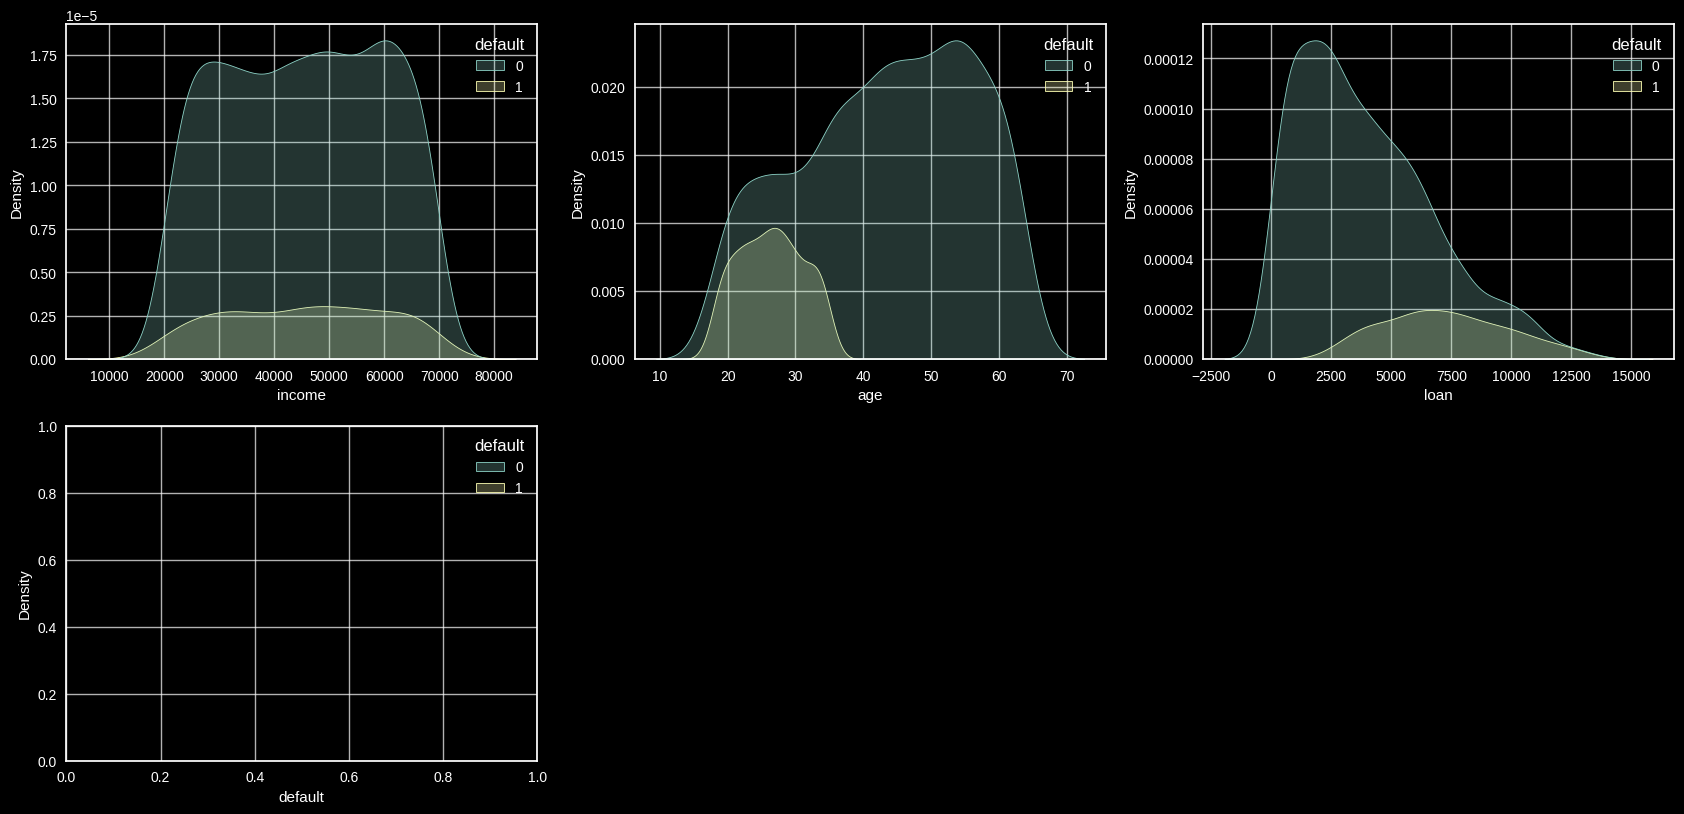

In [ ]:
helper.feature_distribution_all(df)

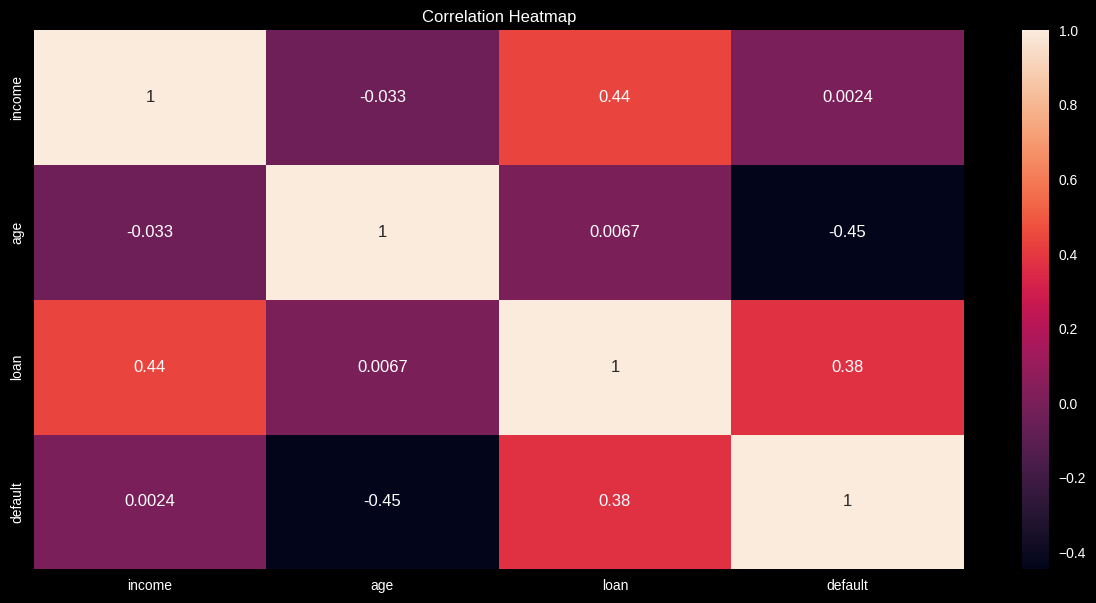

In [ ]:
helper.plot_numeric_correlation_heatmap(df, figsize=(15, 7))

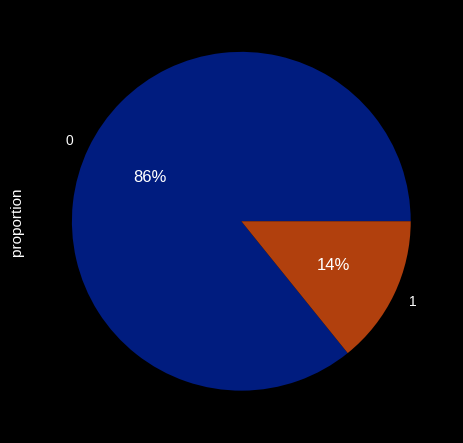

In [ ]:
helper.y_propotion(df)

In [ ]:
clf = setup(data=df, target='default', preprocess=True,
            numeric_features=['income', 'age', 'loan'], session_id=42)

,Description,Value
0,Session id,42
1,Target,default
2,Target type,Binary
3,Original data shape,"(1994, 4)"
4,Transformed data shape,"(1994, 4)"
5,Transformed train set shape,"(1395, 4)"
6,Transformed test set shape,"(599, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9857,0.9989,0.9395,0.9609,0.9489,0.9406,0.9414,0.0660
lightgbm,Light Gradient Boosting Machine,0.9857,0.9987,0.9495,0.9525,0.9497,0.9413,0.9422,0.3810
catboost,CatBoost Classifier,0.9857,0.9989,0.9447,0.9589,0.9489,0.9406,0.9425,2.5320
ada,Ada Boost Classifier,0.9856,0.9960,0.9495,0.9526,0.9497,0.9413,0.9422,0.1530
dt,Decision Tree Classifier,0.9849,0.9765,0.9647,0.9343,0.9482,0.9395,0.9403,0.0300
gbc,Gradient Boosting Classifier,0.9821,0.9968,0.9142,0.9592,0.9347,0.9244,0.9256,0.2430
rf,Random Forest Classifier,0.9814,0.9977,0.9042,0.9638,0.9318,0.9210,0.9224,0.4620
et,Extra Trees Classifier,0.9764,0.9976,0.8797,0.9560,0.9128,0.8992,0.9025,0.1980
qda,Quadratic Discriminant Analysis,0.9749,0.9957,0.8895,0.9385,0.9108,0.8963,0.8983,0.0570
lr,Logistic Regression,0.9462,0.9842,0.7887,0.8465,0.8087,0.7780,0.7835,0.0560


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9929,0.9992,0.9500,1.0000,0.9744,0.9702,0.9706
1,0.9857,0.9996,1.0000,0.9091,0.9524,0.9440,0.9455
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9857,1.0000,0.9000,1.0000,0.9474,0.9391,0.9409
4,0.9786,0.9983,0.8500,1.0000,0.9189,0.9067,0.9106
5,0.9928,1.0000,0.9474,1.0000,0.9730,0.9688,0.9693
6,0.9784,0.9987,0.9474,0.9000,0.9231,0.9105,0.9109
7,0.9856,0.9975,0.9500,0.9500,0.9500,0.9416,0.9416
8,0.9856,0.9996,0.9500,0.9500,0.9500,0.9416,0.9416


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

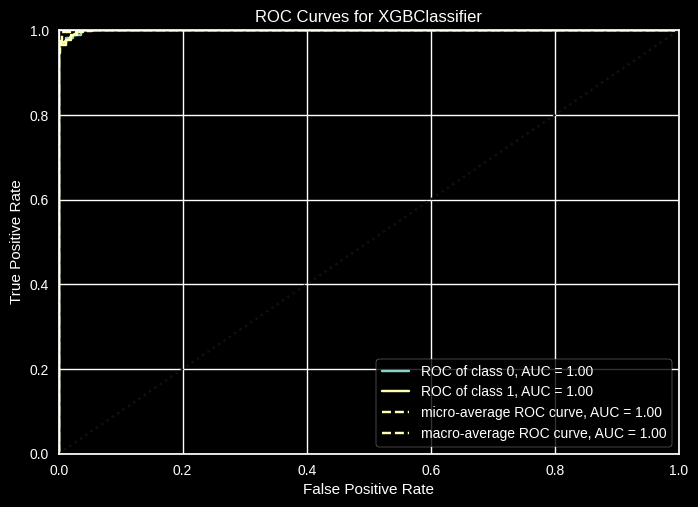

In [ ]:
plot_model(estimator = xgb, plot = 'auc')

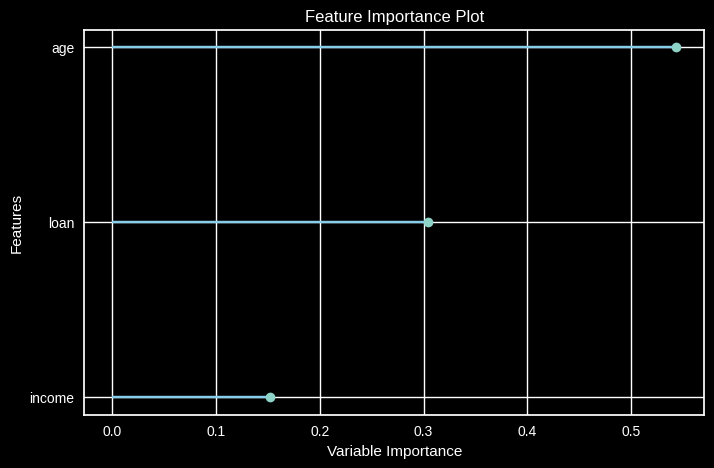

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
model_params = best.get_params()
print(model_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cpu', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'auto', 'validate_parameters': None, 'verbosity': 0}


In [ ]:
import json
with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

In [ ]:
save_model(best, 'first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['income', 'age', 'loan'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=Simple...
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
     

In [ ]:
loaded_best_pipeline = load_model('first_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['income', 'age', 'loan'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transfo...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

In [ ]:
new_data = pd.DataFrame({
    'income': [50000],
    'age': [30],
    'loan': [20000]
})

predictions = predict_model(loaded_best_pipeline, data=new_data)
print(predictions)

   income  age   loan  prediction_label  prediction_score
0   50000   30  20000                 1            0.9996
